In [76]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# set the aesthetic style of the plots
sns.set_style()

# filter warning messages
import warnings
warnings.filterwarnings('ignore')

In [77]:
X_processed = pd.read_csv('saved/clustered_data.csv')


In [78]:
from sklearn.feature_selection import f_classif

X = X_processed.drop(columns=['Cluster', 'target_default'])
y = X_processed['Cluster']

print("Cluster in df_normalized:", 'Cluster' in X_processed.columns)  # Should be True
print("Cluster in X:", 'Cluster' in X.columns)  # Should be False



f_scores, p_values = f_classif(X, y)

# Create a DataFrame to display results
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'P-Value': p_values
})

# Sort by F-Score (higher F-Score means more important)
feature_importance = feature_importance.sort_values(by='F-Score', ascending=False)

print(feature_importance)

Cluster in df_normalized: True
Cluster in X: False
                          Feature       F-Score  P-Value
67            facebook_profile_sq           inf      0.0
11               facebook_profile           inf      0.0
43     score_2_x_facebook_profile  2.487533e+04      0.0
42     score_1_x_facebook_profile  1.134373e+04      0.0
61             state_x_real_state  7.192327e+03      0.0
..                            ...           ...      ...
56                    score_1_bin           NaN      NaN
57                    score_2_bin           NaN      NaN
58      score_1_bin_x_score_2_bin           NaN      NaN
59  score_1_bin_x_fraud_score_bin           NaN      NaN
60  score_2_bin_x_fraud_score_bin           NaN      NaN

[68 rows x 3 columns]


In [79]:
# X = X.drop(columns=["score_2_bin_x_fraud_score_bin", 
#                 "score_1_bin_x_fraud_score_bin",
#                 "score_1_bin_x_score_2_bin",
#                 "score_2_bin",
#                 "score_1_bin"])
X.nunique().sort_values()

score_2_bin_x_fraud_score_bin        1
score_1_bin_x_fraud_score_bin        1
score_1_bin_x_score_2_bin            1
score_2_bin                          1
score_1_bin                          1
                                 ...  
score_5                          41741
score_4                          41741
reported_income_div_income       41741
avg_score_5_6                    41741
score_4_minus_score_3            41741
Length: 68, dtype: int64

In [80]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41741 entries, 0 to 41740
Data columns (total 68 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   score_1                                          41741 non-null  float64
 1   score_2                                          41741 non-null  float64
 2   score_3                                          41741 non-null  float64
 3   score_4                                          41741 non-null  float64
 4   score_5                                          41741 non-null  float64
 5   score_6                                          41741 non-null  float64
 6   risk_rate                                        41741 non-null  float64
 7   last_amount_borrowed                             41741 non-null  float64
 8   last_borrowed_in_months                          41741 non-null  float64
 9   credit_limit                

In [81]:

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.3)
print(len(X_train), len(X_test))
print("NaN in X_train:", X_train.isna().sum().sum())
print("NaN in y_train:", y_train.isna().sum())
print("Infinite values in X:", np.isinf(y_train.values).sum())

29218 12523
NaN in X_train: 0
NaN in y_train: 0
Infinite values in X: 0


In [82]:
# scaler = MinMaxScaler().fit(X_train)
# X_train = scaler.transform(X_train)

# resample
# rus = RandomUnderSampler()
# X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance clusters
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_rus, y_train_rus = smote.fit_resample(X_train, y_train)

X_train_rus, y_train_rus = (X_train, y_train)

# Check new cluster distribution
# print(pd.Series(y_train_rus).value_counts())

# print(X_train_rus)


In [83]:
# define the function val_model
def val_model(X, y, clf, show=True):
    """
    Apply cross-validation on the training set.

    # Arguments
        X: DataFrame containing the independent variables.
        y: Series containing the target vector.
        clf: Scikit-learn estimator instance.
        
    # Returns
        float, mean value of the cross-validation scores.
    """   
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(MinMaxScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if show == True:
        print(f'Recall: {scores.mean()}, {scores.std()}')
    
    return scores.mean()

        score_1   score_2   score_3   score_4   score_5   score_6  risk_rate  \
33321  0.000000  0.823529  0.363636  0.267109  0.308523  0.563344   0.522222   
5134   0.500000  0.470588  0.505051  0.431195  0.095527  0.562550   0.233333   
32072  0.000000  0.617647  0.343434  0.388661  0.936615  0.399435   0.322222   
36243  0.500000  0.176471  0.494949  0.493759  0.259392  0.405441   0.255556   
24588  0.500000  0.441176  0.262626  0.562254  0.315270  0.526851   0.233333   
27508  0.500000  0.264706  0.454545  0.531411  0.566727  0.523666   0.300000   
7497   0.500000  0.764706  0.363636  0.474703  0.796397  0.322408   0.166667   
35021  0.166667  0.500000  0.393939  0.376483  0.591507  0.360617   0.122222   
993    0.500000  0.470588  0.222222  0.392862  0.410315  0.559853   0.211111   
35609  0.500000  0.470588  0.292929  0.369871  0.476337  0.602834   0.344444   

       last_amount_borrowed  last_borrowed_in_months  credit_limit  ...  \
33321              0.000000                 

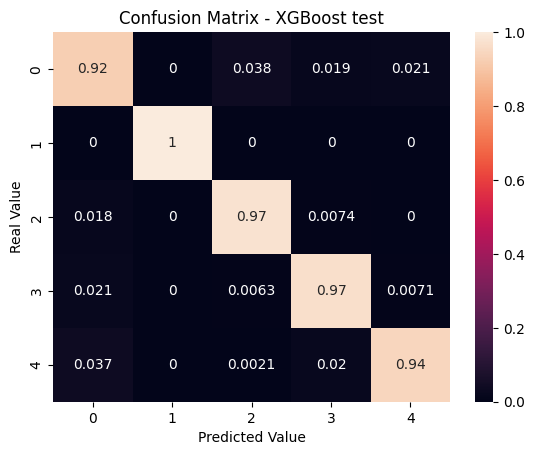

AUC Score: 0.9987825216701726


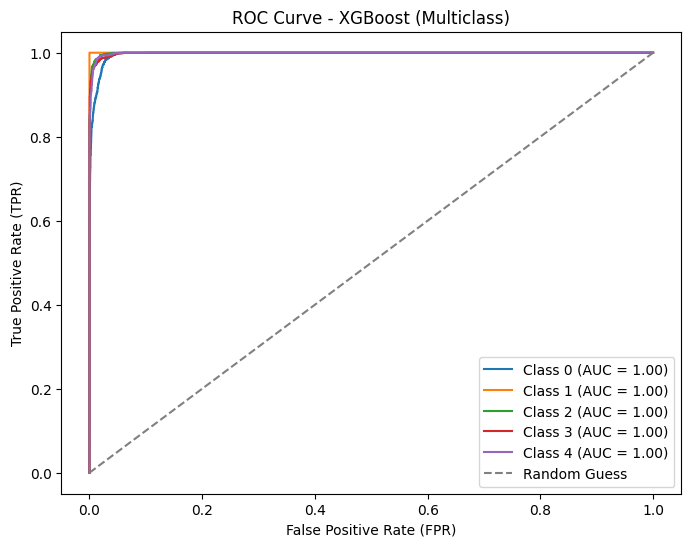

In [84]:
# final XGBoost model
xgb = XGBClassifier(
    max_depth=5, 
    learning_rate=0.01,  
    n_estimators=200, 
    gamma=1,  
    min_child_weight=6,  
    # subsample=0.8,  
    # colsample_bytree=0.8,  
    # reg_lambda=1,  
    # reg_alpha=0.1
)

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# xgb = RandomForestClassifier(
#     n_estimators=200,  # Number of trees in the forest
#     max_depth=8,        # Maximum depth of the trees
#     #... other hyperparameters (e.g., min_samples_split, min_samples_leaf, etc.)...
#     random_state=42,     # For reproducibility
# )

# xgb = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, algorithm='SAMME', random_state=42)  # Adjust parameters
xgb.fit(X_train_rus, y_train_rus)
# prediction
scaler = MinMaxScaler().fit(X_test)
X_test_xgb = X_test #scaler.transform(X_test)
print(X_test_xgb.head(10))
y_pred_xgb = xgb.predict(X_test_xgb)

# classification report
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - XGBoost test')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()





from sklearn.preprocessing import label_binarize
y_pred_xgb = xgb.predict_proba(X_test_xgb)
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

auc_score = roc_auc_score(y_test_binarized, y_pred_xgb)
print("AUC Score:", auc_score)

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_xgb[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_xgb[:, i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - XGBoost (Multiclass)')
plt.legend()
plt.show()

In [85]:
import pickle

# Save label encoders to disk
with open('saved/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb, f)